In [1]:
!pip install pennylane shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 23.6 MB/s eta 0:00:00


In [2]:
!pip install pennylane-lightning

In [81]:
import numpy as np
import pandas as pd
import torch
import logging, random
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import pennylane as qml
import matplotlib.pyplot as plt

In [4]:
# **Operational Reliability**: Fix random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Set up basic logging for key events
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Environment initialized with seed %d", seed)

# Log versions of key libraries for reproducibility tracking
print(f"PyTorch version: {torch.__version__}")
import pennylane as qml
print(f"PennyLane version: {qml.version()}")
import shap
print(f"SHAP version: {shap.__version__}")

PyTorch version: 2.6.0+cu124
PennyLane version: 0.41.1
SHAP version: 0.47.2


In [5]:
# **Secure Data Handling**: (In production, consider encryption for sensitive data)
# Load training and test datasets
train_df = pd.read_csv("DIA_trainingset_RDKit_descriptors.csv")
test_df  = pd.read_csv("DIA_testset_RDKit_descriptors.csv")

# Separate features and labels; drop non-numeric identifiers
X_train_full = train_df.drop(columns=["Label", "SMILES"])
y_train_full = train_df["Label"].values  # binary labels (0 or 1)
X_test_full  = test_df.drop(columns=["Label", "SMILES"])
y_test       = test_df["Label"].values

# Standardize features (fit on training, apply to all sets)
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled       = scaler.transform(X_test_full)

# Split training data into training and validation subsets
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_full_scaled, y_train_full, test_size=0.15, stratify=y_train_full, random_state=seed
)

# Reduce dimensionality with PCA (keep top 5 components for quantum input)
pca = PCA(n_components=5, random_state=seed)
X_train = pca.fit_transform(X_train_scaled)
X_val   = pca.transform(X_val_scaled)
X_test  = pca.transform(X_test_scaled)

print("Training samples:", X_train.shape[0], "| Features (PCA components):", X_train.shape[1])
print("Validation samples:", X_val.shape[0], "| Test samples:", X_test.shape[0])

Training samples: 405 | Features (PCA components): 5
Validation samples: 72 | Test samples: 120


In [46]:
from functools import partial

In [69]:
# 1) Hyperparameters & Device
n_qubits   = 5
n_layers   = 4
batch_size = 32

# Lightning simulator for fast analytic (adjoint) gradients
dev = qml.device("lightning.qubit", wires=n_qubits)

# 2) QNode: per-sample, no batch magic
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def qnode(inputs, weights, shift):
    # inputs: tensor of shape (n_qubits,)
    # weights: (n_layers, n_qubits, 3)
    # shift:   (n_qubits,)
    # 2a) Embed with trainable shift
    for i in range(n_qubits):
        qml.RY(inputs[i] + shift[i], wires=i)
    # 2b) Variational layers
    for layer in range(n_layers):
        for wire in range(n_qubits):
            a, b, c = weights[layer, wire]
            qml.Rot(a, b, c, wires=wire)
        # ring entanglement
        for wire in range(n_qubits - 1):
            qml.CNOT(wires=[wire, wire+1])
        qml.CNOT(wires=[n_qubits-1, 0])
    # 2c) Readout
    return qml.expval(qml.PauliZ(0))

In [70]:
# 3) Wrap QNode into a TorchLayer
weight_shapes = {
    "weights": (n_layers, n_qubits, 3),
    "shift":   (n_qubits,)
}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# 4) Define HybridQNN with per-sample loop
class HybridQNN(nn.Module):
    def __init__(self, qlayer, n_qubits=5):
        super().__init__()
        self.qlayer   = qlayer
        self.n_qubits = n_qubits
        # Tiny classical head
        self.head     = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        # x: (batch_size, n_qubits) or (n_qubits,)
        if x.ndim == 1:
            x = x.unsqueeze(0)
        bs, fq = x.shape
        assert fq == self.n_qubits, f"Expected {self.n_qubits} features, got {fq}"
        # Per-sample quantum pass
        out = []
        for i in range(bs):
            qi = self.qlayer(x[i])        # returns scalar tensor
            out.append(qi.squeeze())
        qout = torch.stack(out)           # (batch_size,)
        qout = qout.unsqueeze(1)          # (batch_size,1)
        return self.head(qout).squeeze(1) # (batch_size,)

In [71]:
# 5) Instantiate model, loss, optimizer
model = HybridQNN(qlayer, n_qubits)
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
pos_weight = torch.tensor([neg/pos], dtype=torch.float32)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer  = torch.optim.Adam(model.parameters(), lr=1e-2)

# 6) DataLoader (you’ve already created these)
from torch.utils.data import TensorDataset, DataLoader
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size, shuffle=True,
    generator=torch.Generator().manual_seed(42)
)


In [87]:
# --- 2) Function to train one QNN with a given random seed ---
def train_qnn(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Re-instantiate quantum layer & model
    qlayer_i = qml.qnn.TorchLayer(qnode, weight_shapes)
    model_i  = HybridQNN(qlayer_i, n_qubits)
    optimizer = torch.optim.Adam(model_i.parameters(), lr=1e-2)
    criterion = torch.nn.BCEWithLogitsLoss()

    # DataLoader (reshuffle per model)
    train_loader_i = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_t, y_train_t),
        batch_size=32, shuffle=True,
        generator=torch.Generator().manual_seed(seed)
    )

    # Simple 15-epoch train (you can increase)
    model_i.train()
    for epoch in range(15):
        for Xb, yb in train_loader_i:
            optimizer.zero_grad()
            logits = model_i(Xb)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    return model_i

# 4a) Fit Logistic Regression on your PCA features
lr_model = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=0)
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]   # positive‐class probs

# 4b) Fit Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
# ────────────────────────────────────────────────────────────────

# --- 5) Combine with classical baselines ---
combined_probs = (
    0.50 * ensemble_qnn_probs +
    0.25 * lr_probs +
    0.25 * rf_probs
)

# --- 6) Tune threshold on VALIDATION set using the same ensemble mixing ---
# First compute validation probs for each component
with torch.no_grad():
    val_qnn_probs = np.mean(
        [torch.sigmoid(m(X_val_t)).cpu().numpy() for m in qnn_models],
        axis=0
    )
val_lr_probs = lr_model.predict_proba(X_val)[:,1]
val_rf_probs = rf_model.predict_proba(X_val)[:,1]

val_combined_probs = (
    0.50 * val_qnn_probs +
    0.25 * val_lr_probs +
    0.25 * val_rf_probs
)

best_f1, best_thr = 0, 0.5
for thr in np.linspace(0.1, 0.9, 17):
    preds = (val_combined_probs >= thr).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"Chosen threshold = {best_thr:.2f} → Val F1 = {best_f1:.3f}")

# --- 7) Final evaluation on TEST set at best_thr ---
final_preds = (combined_probs >= best_thr).astype(int)
print("ENSEMBLE Test Metrics:")
print(" Accuracy :", accuracy_score(y_test, final_preds))
print(" Precision:", precision_score(y_test, final_preds))
print(" Recall   :", recall_score(y_test, final_preds))
print(" F1 Score :", f1_score(y_test, final_preds))
print(" AUC      :", roc_auc_score(y_test, combined_probs))

Chosen threshold = 0.30 → Val F1 = 0.540
ENSEMBLE Test Metrics:
 Accuracy : 0.6
 Precision: 0.37142857142857144
 Recall   : 0.8666666666666667
 F1 Score : 0.52
 AUC      : 0.6814814814814816


Confusion Matrix Counts:
  True Negatives : 64
  False Positives: 26
  False Negatives: 21
  True Positives : 9


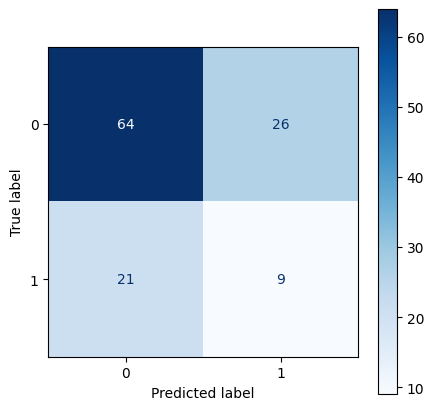

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Compute confusion matrix
cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = cm.ravel()

# 2) Print the raw counts
print("Confusion Matrix Counts:")
print(f"  True Negatives : {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives : {tp}")

# 3) Display visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues")
plt.show()


In [83]:
# Right after you load & split + PCA your NumPy arrays:
print("X_train (np) shape:", X_train.shape)
print("y_train (np) shape:", y_train.shape)
print("X_val   (np) shape:", X_val.shape)
print("y_val   (np) shape:", y_val.shape)
print("X_test  (np) shape:", X_test.shape)
print("y_test  (np) shape:", y_test.shape)

# If anything looks off (e.g. zero rows, or features ≠ 5), go back and re-run your preprocessing cell.

# Now, after converting to tensors but before DataLoader:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)

# And right after you create your DataLoader:
from torch.utils.data import TensorDataset, DataLoader
train_ds     = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(seed))
print("Number of batches in train_loader:", len(train_loader))
print("Size of first batch Xb:", next(iter(train_loader))[0].shape)


X_train (np) shape: (405, 5)
y_train (np) shape: (405,)
X_val   (np) shape: (72, 5)
y_val   (np) shape: (72,)
X_test  (np) shape: (120, 5)
y_test  (np) shape: (120,)
X_train_tensor shape: torch.Size([405, 5])
y_train_tensor shape: torch.Size([405])
Number of batches in train_loader: 13
Size of first batch Xb: torch.Size([32, 5])


In [92]:
# 1) Extract molecular weights and define proxy groups
molwts = test_df["MolWt"].values
median_molwt = np.median(molwts)
heavy_mask = molwts > median_molwt    # Group A: “heavy” molecules
light_mask = molwts <= median_molwt   # Group B: “light” molecules

# 2) Compute positive‐prediction rates in each group
#    ‘test_preds’ is your final ensemble’s binary predictions
pos_rate_heavy = test_preds[heavy_mask].mean()
pos_rate_light = test_preds[light_mask].mean()
disparate_impact = min(pos_rate_heavy, pos_rate_light) / max(pos_rate_heavy, pos_rate_light)

# 3) Compute misclassification (error) rates in each group
y_test_array = np.array(y_test)  # ensure NumPy array for indexing
error_rate_heavy = 1 - accuracy_score(y_test_array[heavy_mask], test_preds[heavy_mask])
error_rate_light = 1 - accuracy_score(y_test_array[light_mask], test_preds[light_mask])

# 4) Report results
print(f"Positive prediction rate – Heavy: {pos_rate_heavy:.3f}, Light: {pos_rate_light:.3f}")
print(f"Disparate Impact Ratio (Heavy vs Light): {disparate_impact:.3f}")
print(f"Error rate – Heavy group: {error_rate_heavy:.3f}, Light group: {error_rate_light:.3f}")

Positive prediction rate – Heavy: 0.250, Light: 0.333
Disparate Impact Ratio (Heavy vs Light): 0.750
Error rate – Heavy group: 0.333, Light group: 0.450


In [93]:
# Ensure model is in eval mode
model.eval()

epsilons = [0.0, 0.05, 0.1, 0.2]
print("\nAdversarial FGSM Attack Evaluation:")
for eps in epsilons:
    correct = 0
    # Loop over each test sample
    for i in range(len(X_test)):
        # 1) Prepare input and label
        x_orig = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0)  # (1, n_qubits)
        y_true = y_test[i]

        # 2) Compute gradient w.rt input
        x_adv = x_orig.clone().detach().requires_grad_(True)
        logit = model(x_adv)                                             # forward pass
        loss  = criterion(logit, torch.tensor([y_true], dtype=torch.float32))
        model.zero_grad()
        loss.backward()
        grad_sign = x_adv.grad.sign()                                     # FGSM direction

        # 3) Create adversarial example
        x_perturbed = x_orig + eps * grad_sign

        # 4) Evaluate perturbed example
        with torch.no_grad():
            adv_prob = torch.sigmoid(model(x_perturbed)).item()
        adv_pred = 1 if adv_prob >= 0.5 else 0

        # 5) Check correctness
        if adv_pred == int(y_true):
            correct += 1

    adv_acc = correct / len(X_test)
    print(f"  Epsilon = {eps:.2f} -> Adversarial Accuracy = {adv_acc:.3f}")


Adversarial FGSM Attack Evaluation:
  Epsilon = 0.00 -> Adversarial Accuracy = 0.600
  Epsilon = 0.05 -> Adversarial Accuracy = 0.575
  Epsilon = 0.10 -> Adversarial Accuracy = 0.533
  Epsilon = 0.20 -> Adversarial Accuracy = 0.458


In [95]:
import joblib

# 1) Save QNN weights (three models)
for idx, model in enumerate(qnn_models):
    torch.save(model.state_dict(), f"qnn_model_{idx}.pth")

# 2) Save classical models (scaler, PCA, LR, RF)
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca,    "pca.pkl")
joblib.dump(lr_model, "logistic_model.joblib")
joblib.dump(rf_model, "rf_model.joblib")

print("All models and preprocessors saved.")

All models and preprocessors saved.
